**Before You Start**: Make sure that you ran `0_setup_workshop.ipynb`!

# ECG Arrhythmia detection

This project aims to demonstrate the Anomaly Detection module implemented in Darts
### Dataset
The MIT-BIH Supraventricular Arrhythmia Database (SVDB) contains 2 channels, and 78 half-hour ECG recordings obtained from 47 objects between 1975-1979.

### Task
Develop an anomaly detection model to identity arrhythmia in the ECG signal.

## Task #1
### Load data of a patient into a darts timeseries object

In [36]:
patient_number = '842'

In [37]:
import os
from darts import TimeSeries

# Load data into darts TimeSeries object
fpath = os.path.join("data", "anomaly_detection", "multivariate", "SVDB", f"{patient_number}.test.csv")
timeseries = TimeSeries.from_csv(fpath, time_col='timestamp')
ts_ecg = timeseries[['ECG1','ECG2']]
ts_anomaly = timeseries['is_anomaly']

### Visualize signal and anomaly

<Axes: xlabel='timestamp'>

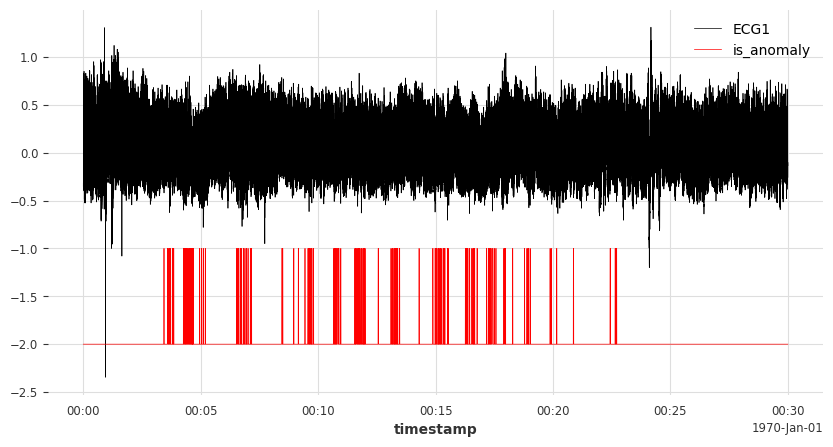

In [38]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1, figsize=(10,5))
ts_ecg['ECG1'].plot(ax=ax,label='ECG1', lw=0.5)
(ts_anomaly-2).plot(ax=ax,label='is_anomaly',color='r', lw=0.5)

## Task #2
### Identify a region of ~15000 datapoints with anomalies (Otherwise training takes a while) and visualize it

In [39]:
# Identify a subset for demonstration
start, end = 15000, 30000
ts_ecg_subset= ts_ecg[start:end]
ts_anomaly_subset = ts_anomaly[start:end]

<Axes: xlabel='timestamp'>

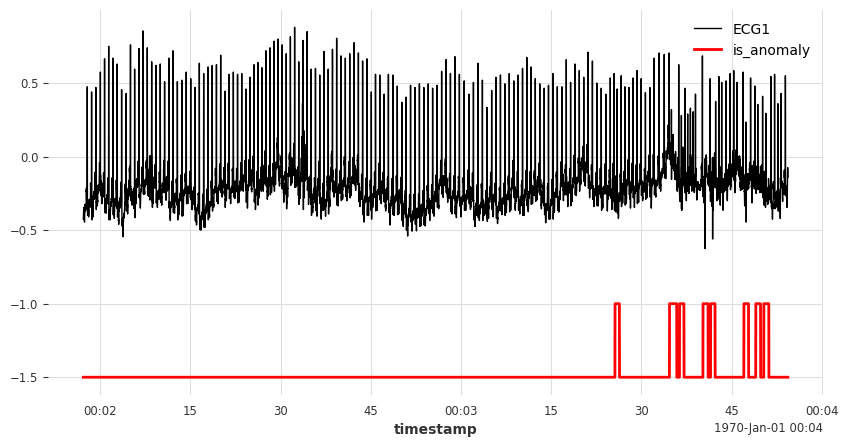

In [40]:
# Visualize the subset
fig,ax = plt.subplots(figsize=(10, 5))
ts_ecg_subset['ECG1'].plot(label='ECG1', lw=1.)
((ts_anomaly_subset/2)-1.5).plot(label='is_anomaly', color='r')

## Task #3
### Create training and test sets (e.g., 10k/5k, 12k/2k datapoints)

In [41]:
# Create train and test dataset for demonstration
train_end, test_end = 10000, 15000 
ts_ecg_train = ts_ecg_subset[:train_end]
ts_ecg_test = ts_ecg_subset[train_end:test_end]
ts_anomaly_test = ts_anomaly_subset[train_end:test_end]

<Axes: xlabel='timestamp'>

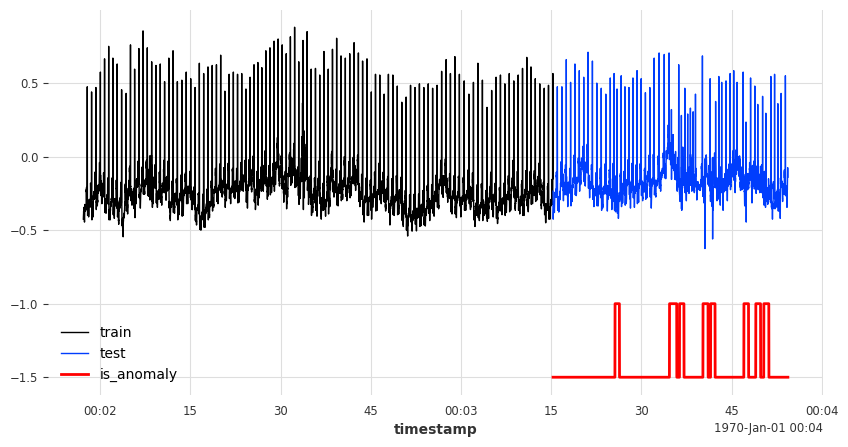

In [42]:
# Visualize the train / test set as well as the test set anomalies
fig,ax = plt.subplots(figsize=(10, 5))
ts_ecg_train['ECG1'].plot(label='train', lw=1.)
ts_ecg_test['ECG1'].plot(label='test', lw=1.)
((ts_anomaly_test/2)-1.5).plot(label='is_anomaly', color='r')

## Task #4
### Assess data properties such as periodicity and identify most common period.

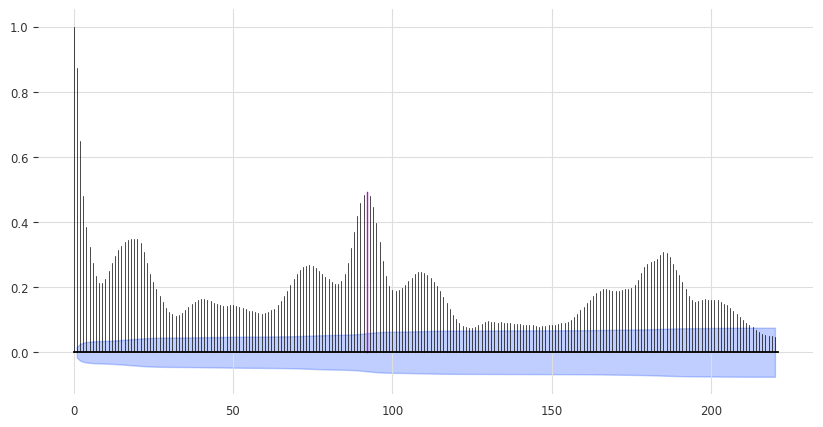

In [43]:
from darts.utils.statistics import plot_acf

# Visualise signal auto correlation to identify most common periodicity
plot_acf(ts=ts_ecg_subset['ECG1'], max_lag=220, m=92)

In [44]:
# Identified most common period
period = 92

## Task #5
### Develop an anomaly detection model step by step by (see figure below):
1. Creating a forecasting model based on the train timeseries ECG data
2. Create historical forecasting for the test timeseries ECG data
3. Create anomaly scores using 2 different scores based on the forecasted and actual ECG signal

<img src="images/ad_inside_anomaly_model.png" alt="Image" width="60%" height="60%">

Links:
- Forecasting models: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html
- Scorers: https://unit8co.github.io/darts/generated_api/darts.ad.scorers.html?highlight=scorer#

#### Create a Forecasting model

In [45]:
from darts.models import LinearRegressionModel

# Instatiate of a forecasting model - e.g. RegressionModel with a defined lag
forecasting_model = LinearRegressionModel(lags=period)

# Train the forecasting model on the training dataset
forecasting_model.fit(ts_ecg_train)

LinearRegressionModel(lags=92, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

<Axes: xlabel='time'>

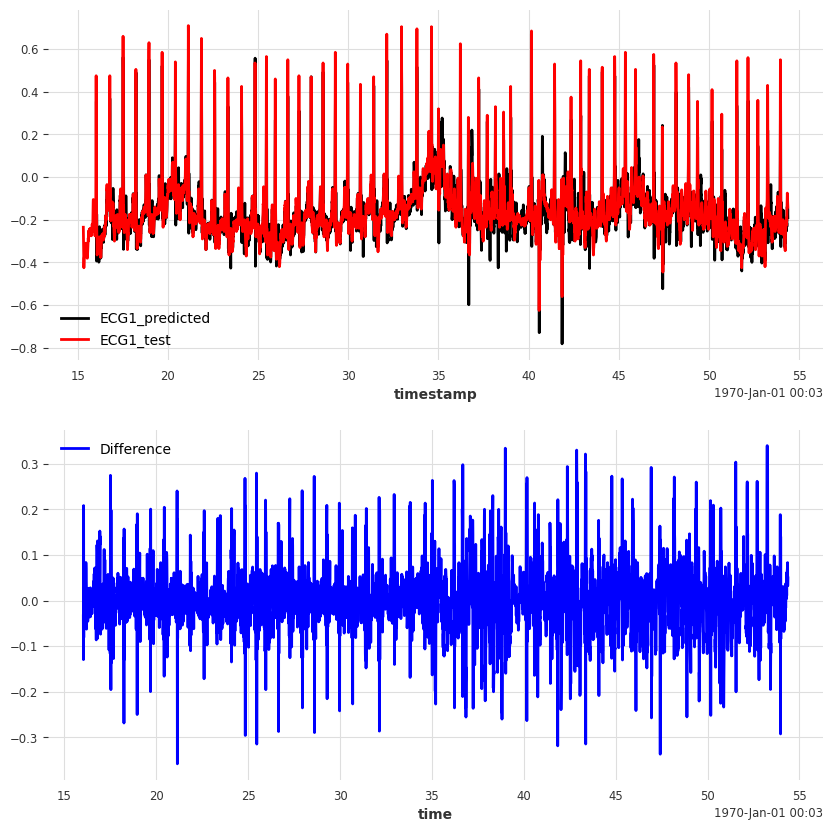

In [46]:
# Visualization of predicted and actual signal
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

# historical predictions
ts_ecg_test_predicted = forecasting_model.historical_forecasts(ts_ecg_test, retrain=False)
# residuals of these predictions = (y_true - y_pred)
ts_ecg_residuals = forecasting_model.residuals(ts_ecg_test, historical_forecasts=ts_ecg_test_predicted)

ts_ecg_test_predicted['ECG1'].plot(ax=ax1, label='ECG1_predicted')
ts_ecg_test['ECG1'].plot(ax=ax1, color='r', label='ECG1_test')
ts_ecg_residuals['ECG1'].plot(ax=ax2, color='b', label='Difference')

#### Use a NormScorer for scoring

In [47]:
from darts.ad.scorers import NormScorer
scorer = NormScorer(ord=1, component_wise=False)

<Axes: xlabel='timestamp'>

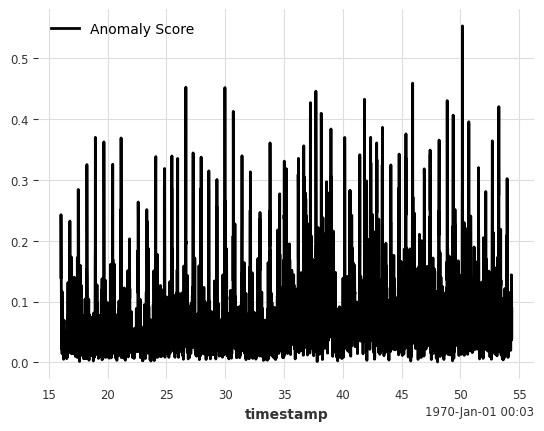

In [48]:
# Calculate anomaly scores by taking the pointwise norm 1 (L1) and visualize the score
scores =  scorer.score_from_prediction(series=ts_ecg_test, pred_series=ts_ecg_test_predicted)
scores.plot(label='Anomaly Score')

In [49]:
# Evaluate the calculated anomaly score using utility methods in darts
from darts.ad.utils import eval_metric_from_scores
eval_metric_from_scores(
    pred_scores=scores, 
    anomalies=ts_anomaly_test, 
    window=1, 
    metric='AUC_ROC'
)

0.6279256480375034

#### Use fittable KMeansScorer for scoring
The Norm scorer calculates the norm between the predicted and actual time series point-wise. Since predicting the peaks of the ECG signals is challenging for the forecasting model, the biggest differences between the actual and predicted values are mostly found at the peak locations.

To overcome the issue from point-wise comparisons, we'll use a windowing approach. This extracts vectors/chunks from an input series by applying a sliding window of width `window` to it. Currently, the scorers that support windowing are `KMeansScorer`, `PyODScorer` and `WasserSteinScorer`. They are also trainable, meaning that we have to fit them first on a set of window vectors/chunks. You want the training set to be anomaly-free!

To fit the scorers, you can either:
- 1) fit it only on some actual time series with `scorer.fit()`, or
- 2) fit it on the difference between some actual series and model forecasts for those series with `scorer.fit_from_prediction()`.

The scoring on new data also has two options (pick the same option as done when fitting): 
- 1) score on some new time series with `scorer.score()`, or
- 2) score on the difference between some new series and model forecasts for those series with `scorer.score_from_prediction()`.
 
In option 2), the scorers simply compute some difference function (e.g. absolute differnce, ...) to reduce the actual series and forecasts into one series. After that, internally it works exactly the same as option 1).

Let's look at `KMeansScorer` as an example. It fits `k` centroids on the windowed anomaly-free input data. To score how anomalous a new series is, it computes the closest centroid distance for each window of that series. If there were any anomalies, then the distances should be larger than any of the anomaly free trainig windows.

The figure below illustrates how the KMeanScorer works when applied directly to a time series with option 1) (or option 2) after taking the difference).

#### Training & Scoring
<img src="images/kmeansscorer.png" alt="Image" width="70%" height="70%">

<img src="images/ad_windowing.png" alt="Image" width="70%" height="70%">

In the example below, we will use the previously developed forecasting model to create historical predictions for the train dataset and train the KMeanScorer on the absolute difference between the actual training and forecasted training datasets (default).

In [50]:
from darts.ad.scorers import KMeansScorer
scorer = KMeansScorer(k=50, window=2*period, component_wise=False, random_state=42)

In [51]:
# Create historical forecasts on the train dataset to later train the scorer
ts_ecg_train_predicted = forecasting_model.historical_forecasts(ts_ecg_train, retrain=False)

In [52]:
scorer.fit_from_prediction(series=ts_ecg_train, pred_series=ts_ecg_train_predicted) 

#### Remark

The function `diff_fn` passed as a parameter to the scorer, will transform `pred_series` and `actual_series` into one series. `diff_fn` can be any of Darts ["per time step" metrics](https://unit8co.github.io/darts/generated_api/darts.metrics.html). By default, it computes the absolute difference (`darts.metrics.ae`). If `pred_series` and `actual_series` are lists of series, `diff_fn` will be applied to all pairwise elements of the sequences.


<Axes: xlabel='time'>

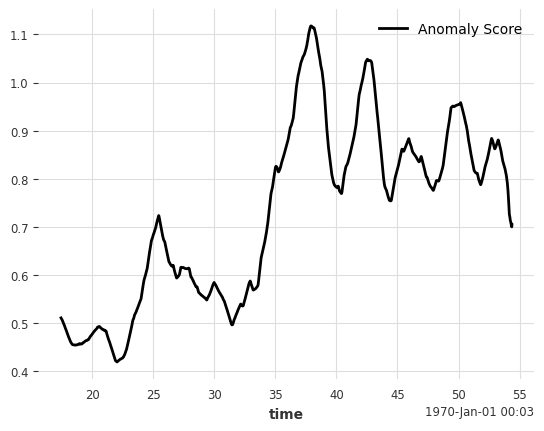

In [53]:
# Use the trained scorer on the forecasted and actual test dataset
scores = scorer.score_from_prediction(series=ts_ecg_test, pred_series=ts_ecg_test_predicted)
scores.plot(label='Anomaly Score')

In [54]:
# Calculate the performance on the scorer using built-in utils methods in darts
eval_metric_from_scores(
    pred_scores=scores,
    anomalies=ts_anomaly_test,
    window=2*period,
    metric='AUC_ROC'
)

0.8533657065626093

## Task #6
### Develop the anomaly detection models by using the Forecasting Anomaly Model via dedicated Darts API interface
This exercise aims to illustrate the power of the darts anomaly detection module by hiding all of the previously made steps under the hood into one dedicated AnomalyModel and corresponding APIs

We'll use the already pretrained forecasting model, but you can also give an un-trained model and call `ForecastingAnomalyModel.fit()` with `allow_model_training=True`.

In [55]:
from darts.ad.anomaly_model.forecasting_am import ForecastingAnomalyModel
from darts.ad.scorers import NormScorer, KMeansScorer

# Instantiate the anomaly model with: one forecasting model, and one or more scorers (and corresponding parameters)
anomaly_model = ForecastingAnomalyModel(
    model=forecasting_model,
    scorer=[
         NormScorer(ord=1),
         KMeansScorer(k=50, window=2*period, component_wise=False, random_state=42)
    ],
)

# Fit anomaly model
anomaly_model.fit(ts_ecg_train, allow_model_training=False)

#### Create anomaly scores and prediction in one step


In [56]:
# Score with the anomaly model (forecasting + scoring)
anomaly_scores, predictions = anomaly_model.score(
    series=ts_ecg_test, return_model_prediction=True
)

### Visualize the forecasted signal as well as the anomalies

<Axes: xlabel='time'>

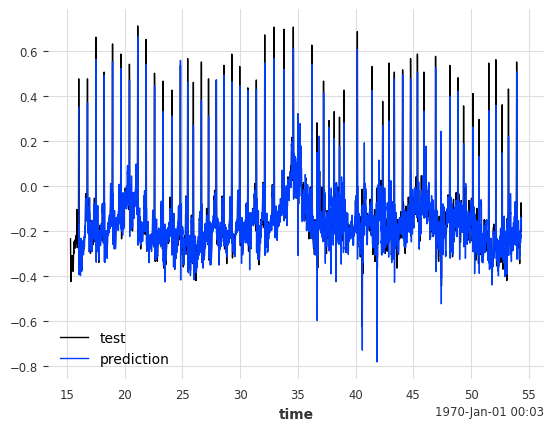

In [57]:
# Forecasting
ts_ecg_test['ECG1'].plot(label='test', lw=1.)
predictions['ECG1'].plot(label='prediction', lw=1.)

<Axes: xlabel='time'>

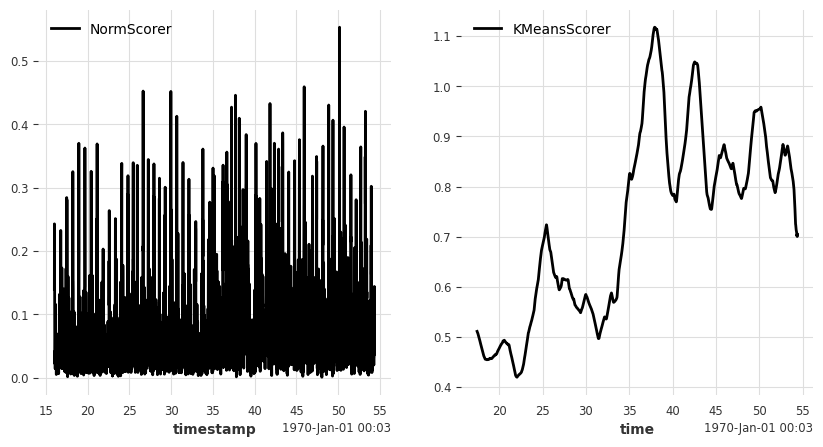

In [58]:
# Anomalies
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
anomaly_scores[0].plot(ax=ax1, label="NormScorer") # indeces corresponding to the scorers
anomaly_scores[1].plot(ax=ax2, label="KMeansScorer") # indeces corresponding to the scorers

### Leverage the inbuilt darts visualization tool to evaluate and show anomalies

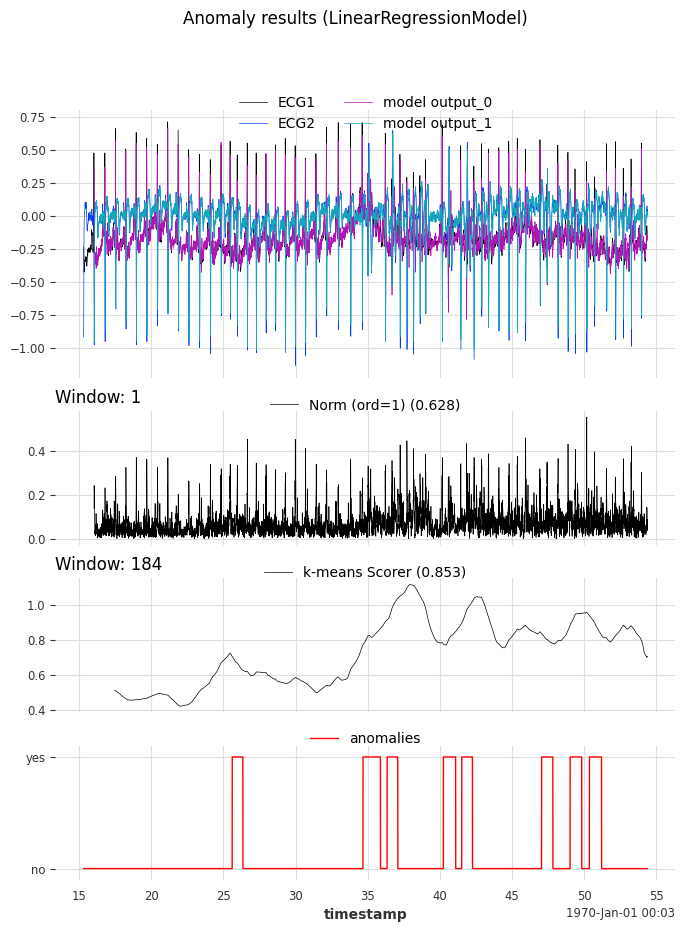

In [59]:
# Visualize and evaluate detection of anomalies
anomaly_model.show_anomalies(
    series=ts_ecg_test,
    anomalies=ts_anomaly_test,
    metric="AUC_ROC",
)

## Task #7
### Use a detector to binarize the anomaly scores

Link:
- https://unit8co.github.io/darts/generated_api/darts.ad.detectors.html?highlight=detector

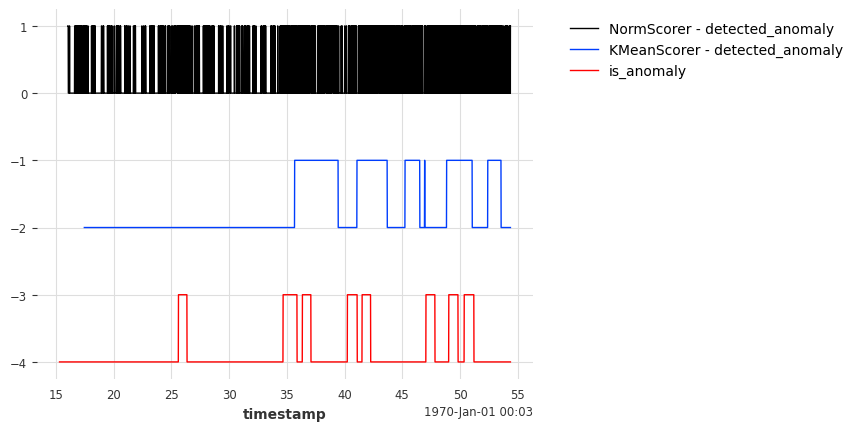

In [60]:
from darts.ad.detectors import QuantileDetector, ThresholdDetector

# Instantiate a detector
detector = QuantileDetector(low_quantile=0, high_quantile=0.70)

fig, ax = plt.subplots()
(detector.fit_detect(anomaly_scores[0])-0).plot(lw=1., label='NormScorer - detected_anomaly')
(detector.fit_detect(anomaly_scores[1])-2).plot(lw=1., label='KMeanScorer - detected_anomaly')
(ts_anomaly_test-4).plot(color='r', lw=1, label='is_anomaly')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

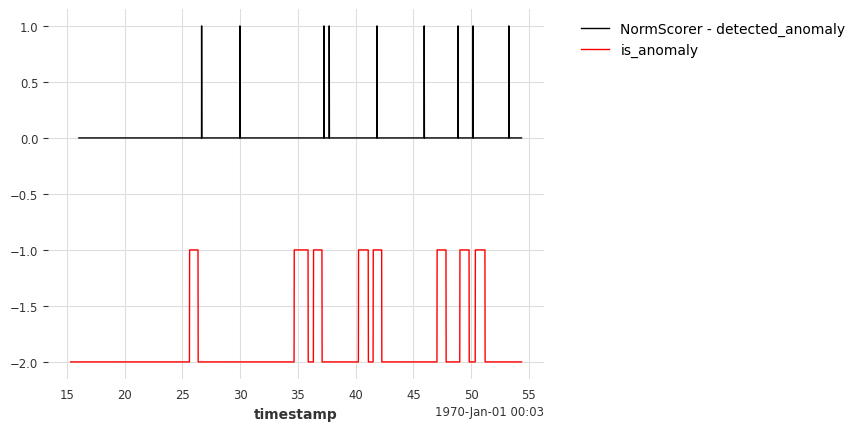

In [61]:
# Instantiate a detector
detector =  ThresholdDetector(low_threshold=0, high_threshold=0.42)

fig, ax = plt.subplots()
(detector.detect(anomaly_scores[0])).plot(lw=1, label='NormScorer - detected_anomaly')
#(detector.detect(anomaly_scores[1])-2).plot(lw=1, label='KMeanScorer - detected_anomaly')
(ts_anomaly_test-2).plot(color='r', lw=1, label='is_anomaly')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')